# Voxel Auto Encoder

### Import Libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Dataset and Dataloader

In [2]:
class VoxelDataset(Dataset):
    """
    Dataset for voxel grids stored as .npy or .npz files
    """
    def __init__(self, folder_path, file_indices=None, file_ext='npy'):
        """
        folder_path: folder containing voxel files
        file_indices: list of file numbers to include
        file_ext: 'npy' or 'npz'
        """
        self.folder_path = folder_path
        self.file_ext = file_ext
        
        if file_indices is None:
            # use all files in folder
            self.file_indices = sorted([
                int(f.split('.')[0]) for f in os.listdir(folder_path) if f.endswith(file_ext)
            ])
        else:
            self.file_indices = file_indices
        
    def __len__(self):
        return len(self.file_indices)
    
    def __getitem__(self, idx):
        file_num = self.file_indices[idx]
        file_path = os.path.join(self.folder_path, f"{file_num:04d}.{self.file_ext}")
        
        if self.file_ext == 'npy':
            voxel = np.load(file_path)
        else:
            data = np.load(file_path)
            if 'voxel_array' in data:
                voxel = data['voxel_array']
            else:
                voxel = list(data.values())[0]
        
        voxel = voxel.squeeze()  # remove channel dim if exists
        voxel = voxel[np.newaxis, ...]  # add channel dim -> (1,D,H,W)
        voxel_tensor = torch.from_numpy(voxel).float()
        return voxel_tensor

In [3]:
# Path to the folder containing voxel files
voxel_folder = "02_dataset/maize_voxels_128cube"

file_indices = range(1, 1046)

# Create Dataset
dataset = VoxelDataset(voxel_folder, file_indices=file_indices, file_ext='npy')

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


### Model Architecture

In [4]:
# ----------------------------
# 3. Encoder and Decoder (128³ version)
# ----------------------------
class VoxelEncoder3D(nn.Module):
    def __init__(self, latent_dim=128):
        super(VoxelEncoder3D, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, 4, 2, 1)    # 128 → 64
        self.bn1 = nn.BatchNorm3d(32)
        
        self.conv2 = nn.Conv3d(32, 64, 4, 2, 1)   # 64 → 32
        self.bn2 = nn.BatchNorm3d(64)
        
        self.conv3 = nn.Conv3d(64, 128, 4, 2, 1)  # 32 → 16
        self.bn3 = nn.BatchNorm3d(128)
        
        self.conv4 = nn.Conv3d(128, 256, 4, 2, 1) # 16 → 8
        self.bn4 = nn.BatchNorm3d(256)
        
        # Updated FC size: 256 * 8 * 8 * 8
        self.fc = nn.Linear(256 * 8 * 8 * 8, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = x.view(x.size(0), -1)
        latent = self.fc(x)
        return latent


class VoxelDecoder3D(nn.Module):
    def __init__(self, latent_dim=128):
        super(VoxelDecoder3D, self).__init__()
        
        # Updated FC size
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8 * 8)
        
        self.deconv1 = nn.ConvTranspose3d(256, 128, 4, 2, 1) # 8 → 16
        self.bn1 = nn.BatchNorm3d(128)
        
        self.deconv2 = nn.ConvTranspose3d(128, 64, 4, 2, 1)  # 16 → 32
        self.bn2 = nn.BatchNorm3d(64)
        
        self.deconv3 = nn.ConvTranspose3d(64, 32, 4, 2, 1)   # 32 → 64
        self.bn3 = nn.BatchNorm3d(32)
        
        self.deconv4 = nn.ConvTranspose3d(32, 1, 4, 2, 1)    # 64 → 128

    def forward(self, x):
        x = self.fc(x)
        
        x = x.view(x.size(0), 256, 8, 8, 8)  # Updated reshape
        
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        
        x = torch.sigmoid(self.deconv4(x))
        return x


class VoxelAutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VoxelAutoEncoder, self).__init__()
        self.encoder = VoxelEncoder3D(latent_dim)
        self.decoder = VoxelDecoder3D(latent_dim)

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent


### Training 

In [5]:
# ----------------------------
# 4. Training Code
# ----------------------------
def train_autoencoder(
    dataloader,
    model,
    device='cuda',
    epochs=500,
    lr=1e-3,
    checkpoint_folder='checkpoints_voxel_AE_128cube',
    start_epoch=0,
    checkpoint_interval=50
):
    os.makedirs(checkpoint_folder, exist_ok=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()  # binary occupancy
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")
        
        # Save checkpoint
        if (epoch+1) % checkpoint_interval == 0:
            ckpt_path = os.path.join(checkpoint_folder, f"autoencoder_epoch{epoch+1}.pth")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")
    
    # Save final model
    final_path = os.path.join(checkpoint_folder, "autoencoder_final.pth")
    torch.save(model.state_dict(), final_path)
    print(f"Training complete. Model saved at {final_path}")




In [6]:
# Resume training from checkpoint
def resume_training(checkpoint_path, model, dataloader, device='cuda', epochs=50, lr=1e-3):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_autoencoder(dataloader, model, device=device, epochs=epochs, start_epoch=start_epoch, checkpoint_folder=os.path.dirname(checkpoint_path))

In [18]:
resume_training(
    checkpoint_path="checkpoints/autoencoder_epoch50.pth",
    model=autoencoder,
    dataloader=dataloader,
    device='cuda',   
    epochs=100,       # train until epoch 50
    lr=1e-3
)

Epoch 51/100 - Loss: 0.004770
Epoch 52/100 - Loss: 0.004706
Epoch 53/100 - Loss: 0.004468
Epoch 54/100 - Loss: 0.004317
Epoch 55/100 - Loss: 0.004232
Saved checkpoint: checkpoints/autoencoder_epoch55.pth
Epoch 56/100 - Loss: 0.004126
Epoch 57/100 - Loss: 0.004009
Epoch 58/100 - Loss: 0.003929
Epoch 59/100 - Loss: 0.003828
Epoch 60/100 - Loss: 0.003741
Saved checkpoint: checkpoints/autoencoder_epoch60.pth
Epoch 61/100 - Loss: 0.003625
Epoch 62/100 - Loss: 0.003565
Epoch 63/100 - Loss: 0.003503
Epoch 64/100 - Loss: 0.003417
Epoch 65/100 - Loss: 0.003393
Saved checkpoint: checkpoints/autoencoder_epoch65.pth
Epoch 66/100 - Loss: 0.003317
Epoch 67/100 - Loss: 0.003222
Epoch 68/100 - Loss: 0.003127
Epoch 69/100 - Loss: 0.003051
Epoch 70/100 - Loss: 0.003031
Saved checkpoint: checkpoints/autoencoder_epoch70.pth
Epoch 71/100 - Loss: 0.002976
Epoch 72/100 - Loss: 0.002910
Epoch 73/100 - Loss: 0.002851
Epoch 74/100 - Loss: 0.002776
Epoch 75/100 - Loss: 0.002733
Saved checkpoint: checkpoints/auto

### Inference

In [5]:
import torch
import numpy as np
import open3d as o3d

def load_model(model, checkpoint_path, device='cuda'):
    """
    Loads a saved PyTorch state_dict into the model.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    print(f"Loaded model from {checkpoint_path}")
    return model


def reconstruct_voxel(model, voxel_file, save_ply_path, device='cuda', voxel_size=0.02):
    """
    Load voxel, run inference, and save reconstructed shape to PLY.
    """
    model.to(device)
    model.eval()

    # Load voxel file
    if voxel_file.endswith(".npy"):
        voxel = np.load(voxel_file)
    else:
        data = np.load(voxel_file)
        voxel = data.get('voxel_array', list(data.values())[0])

    voxel = voxel.squeeze()  # (D,H,W)

    voxel_tensor = torch.from_numpy(voxel).float().unsqueeze(0).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        recon, _ = model(voxel_tensor)

    recon = recon.squeeze().cpu().numpy()  # (D,H,W)

    # Convert to binary occupancy
    recon_binary = (recon > 0.5).astype(np.float32)

    # Extract occupied voxel coordinates
    occupied = np.argwhere(recon_binary > 0)  # (N,3)
    voxel_points = occupied.astype(np.float32) * voxel_size

    # Save as PLY
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_points)
    o3d.io.write_point_cloud(save_ply_path, pcd)

    print(f"Reconstructed voxel saved as PLY: {save_ply_path}")


In [7]:
device = "cuda"

# 1. Create model
model = VoxelAutoEncoder()

# 2. Load weights
model = load_model(
    model,
    "checkpoints_voxel_AE_128cube/autoencoder_final.pth",
    device=device
)

# 3. Run inference on one voxel file
reconstruct_voxel(
    model,
    voxel_file="02_dataset/rotated_voxel/rotated_0001_voxel.npy",
    save_ply_path="reconstructed_0001_rotated.ply",
    device=device
)


NameError: name 'load_model' is not defined

### Inference while training: 2

In [10]:
# ----------------------------
# 5. Inference & save reconstructed voxel as PLY
# ----------------------------
def reconstruct_voxel(model, voxel_file, save_ply_path, device='cuda', voxel_size=0.02):
    """
    voxel_file: path to .npy or .npz voxel file
    """
    model.to(device)
    model.eval()
    
    # Load voxel
    if voxel_file.endswith(".npy"):
        voxel = np.load(voxel_file)
    else:
        data = np.load(voxel_file)
        if 'voxel_array' in data:
            voxel = data['voxel_array']
        else:
            voxel = list(data.values())[0]
    voxel = voxel.squeeze()
    voxel_tensor = torch.from_numpy(voxel).unsqueeze(0).unsqueeze(0).float().to(device)  # (1,1,D,H,W)
    
    with torch.no_grad():
        recon, _ = model(voxel_tensor)
    recon = recon.squeeze().cpu().numpy()  # (D,H,W)
    
    # Threshold to binary occupancy
    recon_binary = (recon > 0.5).astype(np.float32)
    occupied = np.argwhere(recon_binary > 0)
    voxel_points = occupied.astype(np.float32) * voxel_size
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_points)
    o3d.io.write_point_cloud(save_ply_path, pcd)
    print(f"Reconstructed voxel saved as PLY: {save_ply_path}")


In [11]:
input_voxel = "02_dataset/maize_voxels_128cube/0015.npy"
output_ply = "0015_reconstructed_128.ply"

reconstruct_voxel(
    model=autoencoder,
    voxel_file=input_voxel,
    save_ply_path=output_ply,
    device=device,     # 'cuda' or 'cpu'
    voxel_size=0.02    # spacing between voxels in meters (or unit)
)


Reconstructed voxel saved as PLY: 0015_reconstructed_128.ply


### Plotting Latent Vector

In [12]:
import torch
import numpy as np

def extract_latents(model, dataloader, device='cuda'):
    model.to(device)
    model.eval()

    latents = []

    with torch.no_grad():
        for voxel in dataloader:
            voxel = voxel.to(device)
            _, latent = model(voxel)  # latent shape: (B, latent_dim)
            latents.append(latent.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    return latents

In [13]:
latents = extract_latents(autoencoder, dataloader, device='cuda')
print(latents.shape)  # (N, 128)


(1045, 128)


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca_2d(latents):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(latents)

    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], s=10, alpha=0.7)
    plt.title("Latent Space PCA (2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


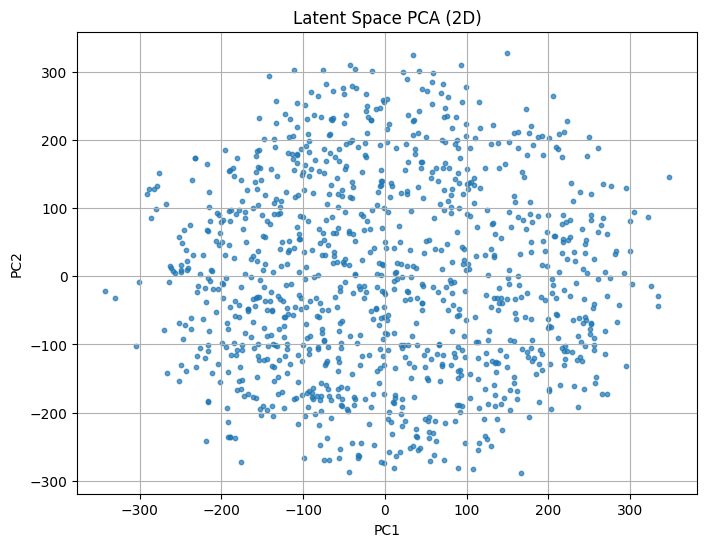

In [16]:
plot_pca_2d(latents)

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_3d(latents):
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(latents)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reduced[:,0], reduced[:,1], reduced[:,2], s=10, alpha=0.7)

    ax.set_title("Latent Space PCA (3D)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.show()


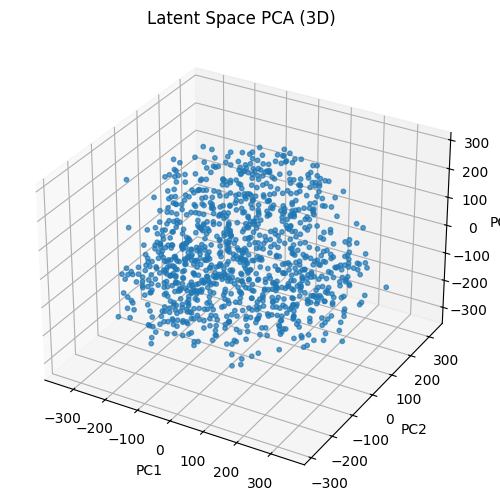

In [18]:
plot_pca_3d(latents)

### U map

In [19]:
! pip install umap-learn

In [20]:
import umap
import matplotlib.pyplot as plt

def plot_umap_2d(latents, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean'
    )

    embedding = reducer.fit_transform(latents)

    plt.figure(figsize=(8,6))
    plt.scatter(embedding[:,0], embedding[:,1], s=10, alpha=0.7)
    plt.title("UMAP Latent Space (2D)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.show()


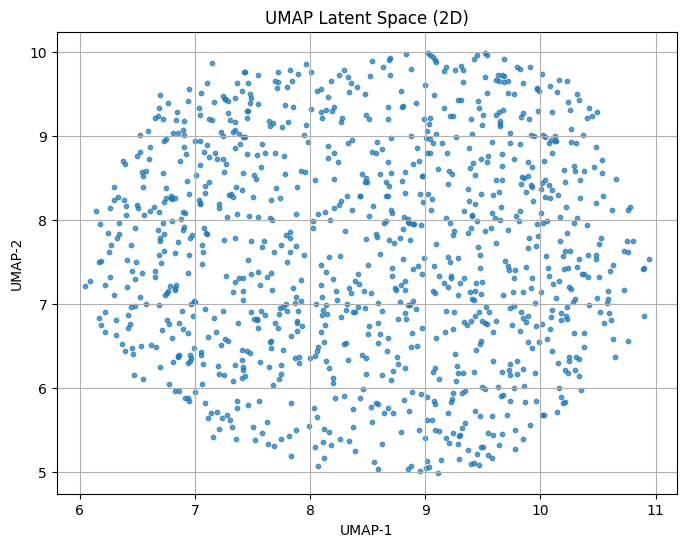

In [21]:
plot_umap_2d(latents)


In [22]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_umap_3d(latents, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,
        metric='euclidean'
    )

    embedding = reducer.fit_transform(latents)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=10, alpha=0.7)

    ax.set_title("UMAP Latent Space (3D)")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")

    plt.show()


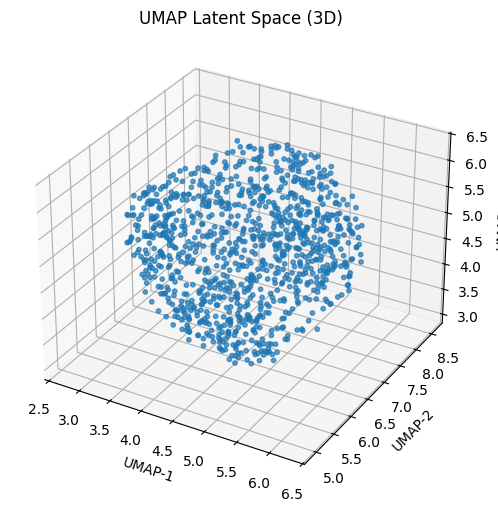

In [23]:
plot_umap_3d(latents)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_tsne_3d(
    latents,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=None
):
    tsne = TSNE(
        n_components=3,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        init='pca',          # more stable than random
        random_state=random_state
    )

    embedding = tsne.fit_transform(latents)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        s=10,
        alpha=0.7
    )

    ax.set_title("Latent Space t-SNE (3D)")
    ax.set_xlabel("t-SNE-1")
    ax.set_ylabel("t-SNE-2")
    ax.set_zlabel("t-SNE-3")

    plt.show()
